<a href="https://colab.research.google.com/github/KasraOstad/Vineyard-Classification-in-Sussex/blob/master/s2time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook was used for time-series analysis of Sentinel-2 data

In [ ]:
#import google earth engine and useful libraries
!pip install folium
!pip install geehydro
import ee
import folium
import geehydro
from datetime import datetime as dt
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt

#Authenticate to the Earth Engine servers
ee.Authenticate()

#Initialize the API
ee.Initialize()


  Created wheel for geehydro: filename=geehydro-0.2.0-py2.py3-none-any.whl size=10113 sha256=11ecbedc9be58cdf328763c9c4647da096e08c67367b92b266a0237a05705471
  Stored in directory: /root/.cache/pip/wheels/c5/07/67/5fa6e7271b46bbe0acafdc7105bbee27a39ab7132d251d822d
Successfully built geehydro
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=cl1MMrb_PxQItp7jaivKHlDnwR_OHr9A_DCQF_dTA3g&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter

In [ ]:
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

In [ ]:
#Sentinel 2 image collection
collection=('COPERNICUS/S2_SR')
s2=ee.ImageCollection(collection)

#Define Area of interest
area_list= list ([(-0.176440,50.825270),(-0.176440,51.144),(-0.560,51.144),(-0.560,50.825270),(-0.176440,50.825270)])
AOI=ee.Geometry.Polygon(area_list)

#Filter image collection with AOI
s2=s2.filterBounds(AOI)

#Filter image collection with date
s2=s2.filterDate('2019-01-01','2020-01-01')

#Total number of images after filtering 
print('Total number:', s2.size().getInfo())


sussex_map=folium.Map(location=[50.9665,-0.2275],zoom_start=10)
folium.Marker([50.825270, -0.176440]).add_to(sussex_map)
folium.Marker([51.144, -0.176440]).add_to(sussex_map)
folium.Marker([51.144, -0.560]).add_to(sussex_map)
folium.Marker([50.825270, -0.560]).add_to(sussex_map)
#sussex_map                   


Total number: 147


In [ ]:
least_cloudy_s2 =  s2.filterMetadata('CLOUD_COVERAGE_ASSESSMENT','less_than',12.5)
print('Total number:', least_cloudy_s2.size().getInfo())

least_cloudy_list=least_cloudy_s2.toList(least_cloudy_s2.size())

def ymdList(imgcol):
    def iter_func(image, newlist):
        date = ee.Number.parse(image.date().format("YYYYMMdd"));
        newlist = ee.List(newlist);
        return ee.List(newlist.add(date).sort())
    ymd = imgcol.iterate(iter_func, ee.List([]))
    return list(ee.List(ymd).reduce(ee.Reducer.frequencyHistogram()).getInfo().keys())

dates=ymdList(least_cloudy_s2)
dates   

Total number: 17


['20190117',
 '20190223',
 '20190226',
 '20190325',
 '20190330',
 '20190419',
 '20190723',
 '20190825',
 '20190827',
 '20190904',
 '20190914',
 '20190919',
 '20190921',
 '20191118',
 '20191203',
 '20191223',
 '20191225']

In [ ]:
#transform the image collection into a List
least_cloudy_list=least_cloudy_s2.toList(least_cloudy_s2.size())

#How to index the image collection:
im_0=ee.Image(least_cloudy_list.get(0))
ndvi_im0 = im_0.normalizedDifference(['B8', 'B4'])

#Process image colection to list of ndvi images
ndvi_list=[]
cloud_list=[]


for i in range(0, least_cloudy_s2.size().getInfo()):
  im=ee.Image(least_cloudy_list.get(i))
  cloud_cover=im.get('CLOUDY_PIXEL_PERCENTAGE').getInfo()
  cloud_list.append(cloud_cover)

  ndvi=im.normalizedDifference(['B8','B4'])
  ndvi_list.append(ndvi)

len(ndvi_list)

17

In [ ]:
#Features of known vineyards:
nutbourne=ee.Feature(ee.Geometry.Polygon(coords = [[[-0.464307, 50.958657], [-0.462859, 50.958934], [-0.462880, 50.957893], [-0.465637, 50.958217], [-0.464307, 50.958657]]])) 
blackdog=ee.Feature(ee.Geometry.Polygon(coords =[[[-0.111095,50.907673], [-0.112039,50.906455], [-0.110086,50.906185], [-0.109464,50.907491], [-0.111095,50.907673]]]))  
stopham=ee.Feature(ee.Geometry.Polygon(coords =[[[-0.539676,50.959777], [-0.536996,50.959608], [-0.537278,50.958873], [-0.540022,50.959107], [-0.539676,50.959777]]]))                                                                       
albury=ee.Feature(ee.Geometry.Polygon(coords =[[[-0.485404,51.229119], [-0.485325,51.226550], [-0.4834528,51.226518], [-0.483390,51.229149], [-0.485404,51.229119]]])) 
coolhurst=ee.Feature(ee.Geometry.Polygon(coords =[[[-0.298754,51.052306], [-0.297863,51.050897], [-0.295439,51.050870], [-0.295567,51.052933], [-0.298754,51.052306]]])) 

vineyards=[nutbourne,blackdog,stopham,albury,coolhurst]
vineyards=ee.FeatureCollection(vineyards)
print(str(vineyards.size().getInfo())+ (' vineyards in feature collection'))

#Features for spring weat
swheat1=ee.Feature(ee.Geometry.Polygon(coords=[[-0.073003,50.843437],[ -0.069657,50.841746],[ -0.064947,50.844764],[-0.068777,50.846315],[-0.073003,50.843437]]))
swheat2=ee.Feature(ee.Geometry.Polygon(coords=[[-0.111360,50.894917],[-0.109171,50.894843],[-0.109584,50.892227],[-0.111569,50.892301],[-0.111360,50.894917]]))


#swheat3=ee.Feature(ee.Geometry.Polygon(coords=[[484746.3125999998, 108484.0392000005], [484706.3125999998, 108484.0392000005], [484686.3125999998 108518.6798], [484706.3125999998, 108553.3203999996], [484746.3125999998, 108553.3203999996], [484766.3125999998 ,108518.6798], [484746.3125999998, 108484.0392000005]
#Features for spring barley
sbarley1=ee.Feature(ee.Geometry.Polygon(coords=[[-0.0777132651725039, 50.88089950524432], [-0.07828152145392488, 50.88090886345682], [-0.07855284274599977, 50.88122486909902], [-0.07825590351954845, 50.88153151848023], [-0.07768763967317188, 50.88152216006128], [-0.07741632261829126, 50.8812061524676], [-0.0777132651725039, 50.88089950524432]]))
sbarley2=ee.Feature(ee.Geometry.Polygon(coords=[[-0.1964218587574342 ,50.86970969251052], [-0.1967179526653116, 50.86940273324883], [-0.1972861075641087, 50.86941151073002], [-0.1975581761169845, 50.86972724766653], [-0.1972620855637946, 50.87003420907953], [-0.1966939231029528, 50.87002543140472], [-0.1964218587574342, 50.86970969251052]]))
sbarley3=ee.Feature(ee.Geometry.Polygon(coords=[[-0.1237930210963419, 50.88040321879293], [-0.1243612865076491, 50.88041235262978], [-0.1246329196508824, 50.88072825441814], [-0.1243362831563063, 50.88103502432384], [-0.1237680101794496, 50.88102589028551], [-0.1234963812628078, 50.88070998654297], [-0.1237930210963419, 50.88040321879293]]))

#Features for grass
grass1=ee.Feature(ee.Geometry.Polygon(coords=[[-0.07410789723823646, 50.98894440841386], [-0.07467747053633884, 50.98895379836258], [-0.07494937685745727, 50.98926981341378], [-0.07465170561651964, 50.98957644047522], [-0.07408212470674314, 50.98956705031921], [-0.0738102226496698, 50.98925103330904], [-0.07410789723823646, 50.98894440841386]]))
grass2=ee.Feature(ee.Geometry.Polygon(coords=[[[-0.2084964824190066, 50.86615718242087], [-0.2087924746738251, 50.86585019130413], [-0.2093605901523409, 50.8658589095793], [-0.209632720936663, 50.86617461916353], [-0.2093367293526937, 50.86648168253753], [-0.2087686063126123, 50.86647296407003], [-0.2084964824190066, 50.86615718242087]]]))
grass3=ee.Feature(ee.Geometry.Polygon(coords=[[[-0.04262071767015235, 50.91770134072426], [-0.04291812537595823, 50.91739478899557], [-0.04348681430840379, 50.9174043214568], [-0.04375810311504533, 50.91772040585708], [-0.04346069866005398, 50.91802696154554], [-0.04289200214749488, 50.91801742887397], [-0.04262071767015235, 50.91770134072426]]]))


swheat1=ee.Feature(ee.Geometry.Polygon(coords=[[-0.787829798627609, 50.85149344013579], [-0.7881219136883607 ,50.85118495494903], [-0.7886900016562076, 50.85119085191556], [-0.788965982125628, 50.85150523419893], [-0.7886738705597852 ,50.85181372150659], [-0.7881057750295234 ,50.85180782440997], [-0.787829798627609, 50.85149344013579]]))
swheat2=ee.Feature(ee.Geometry.Polygon(coords=[[-0.7605946811115151, 50.98921049014588], [-0.761164446377871 ,50.98921653276399], [-0.761441041578989 ,50.9895309772563], [-0.7611478674079323 ,50.98983938112969], [-0.760578094519696, 50.98983333837812], [-0.7603015034244862, 50.9895188918866], [-0.7605946811115151, 50.98921049014588]]))
swheat3=ee.Feature(ee.Geometry.Polygon(coords=[[-0.8111946132001873, 50.91590686067802],[-0.8117634935696565, 50.91591265058909], [-0.8120400055945388, 50.91622698029314], [-0.8117476332186718 ,50.91653552028482], [-0.8111787452585556 ,50.91652973024595], [-0.8109022372650211 ,50.91621540034321], [-0.8111946132001873, 50.91590686067802]]))



5 vineyards in feature collection


In [ ]:
def veg_timeseries(region,metric,list_of_images):
  stats=[]
  for image in list_of_images:
    stat_dict=image.reduceRegion(**{
      'reducer': ee.Reducer.median(),
      'geometry': region.geometry(),
      'scale': 10,
      'maxPixels': 1e9
    })
    if (metric=='ndvi') or (metric=='ndwi'):
      stats.append(stat_dict.getInfo().get('nd'))

    if metric=='evi':
      stats.append(stat_dict.getInfo().get('constant'))
  return stats
  
#NDVI time series calculations 
nutbourne_ndvi=veg_timeseries(nutbourne,'ndvi',ndvi_list)
blackdog_ndvi=veg_timeseries(blackdog,'ndvi',ndvi_list)
stopham_ndvi=veg_timeseries(stopham,'ndvi',ndvi_list)
albury_ndvi=veg_timeseries(albury,'ndvi',ndvi_list)
coolhurst_ndvi=veg_timeseries(coolhurst,'ndvi',ndvi_list)

swheat1_ndvi=veg_timeseries(swheat1,'ndvi',ndvi_list)
swheat2_ndvi=veg_timeseries(swheat2,'ndvi',ndvi_list)
swheat3_ndvi=veg_timeseries(swheat3,'ndvi',ndvi_list)

sbarley1_ndvi=veg_timeseries(sbarley1,'ndvi',ndvi_list)
sbarley2_ndvi=veg_timeseries(sbarley2,'ndvi',ndvi_list)
sbarley3_ndvi=veg_timeseries(sbarley3,'ndvi',ndvi_list)

grass1_ndvi=veg_timeseries(grass1,'ndvi',ndvi_list)
grass2_ndvi=veg_timeseries(grass2,'ndvi',ndvi_list)
grass3_ndvi=veg_timeseries(grass3,'ndvi',ndvi_list)




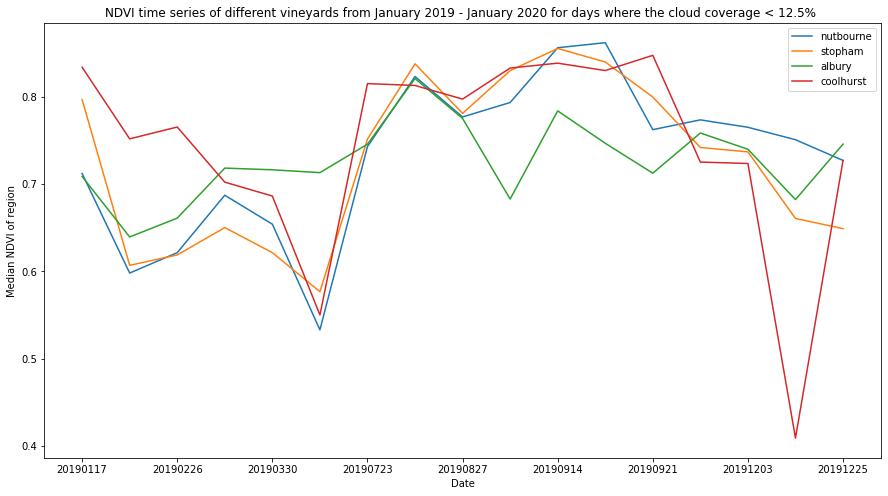

In [ ]:
def plot_timeseries(list_of_regions,list_of_region_names,t):
  for i in range(0,len(list_of_regions)):
    if i==0:
      regions_df=pd.DataFrame(data=list_of_regions[i],index=dates, columns=[list_of_region_names[i]])
    
    regions_df[list_of_region_names[i]]=list_of_regions[i]

  ax=regions_df.plot.line(figsize=(15,8), title=t)
  ax.set_xlabel("Date")
  ax.set_ylabel("Median NDVI of region")
  #return regions_df

compare_vineyards=[nutbourne_ndvi,stopham_ndvi,albury_ndvi,coolhurst_ndvi]
compare_vineyards_names=['nutbourne','stopham','albury','coolhurst']
plot_timeseries(compare_vineyards,compare_vineyards_names,'NDVI time series of different vineyards from January 2019 - January 2020 for days where the cloud coverage < 12.5% ')


Text(0, 0.5, 'Cloud coverage%')

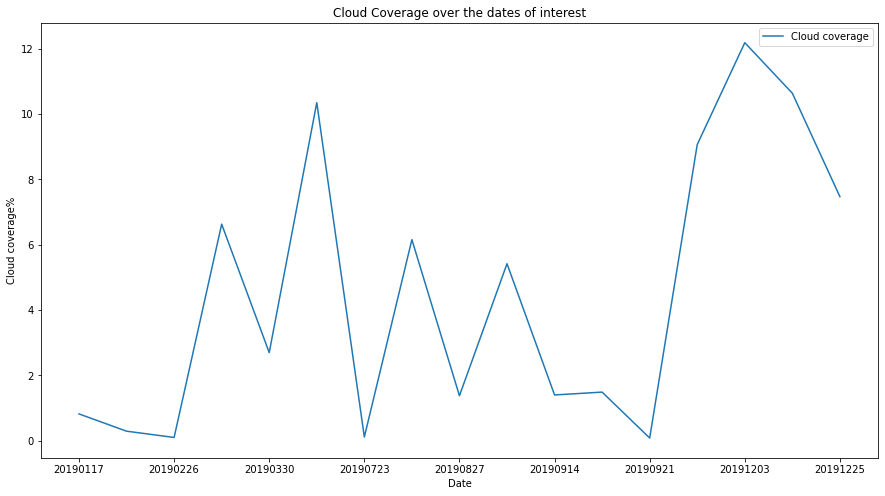

In [ ]:
cloud_df=pd.DataFrame(data=cloud_list,index=dates,columns=['Cloud coverage'])
cloud_ax=cloud_df.plot.line(figsize=(15,8), title='Cloud Coverage over the dates of interest')
cloud_ax.set_xlabel("Date")
cloud_ax.set_ylabel("Cloud coverage%")

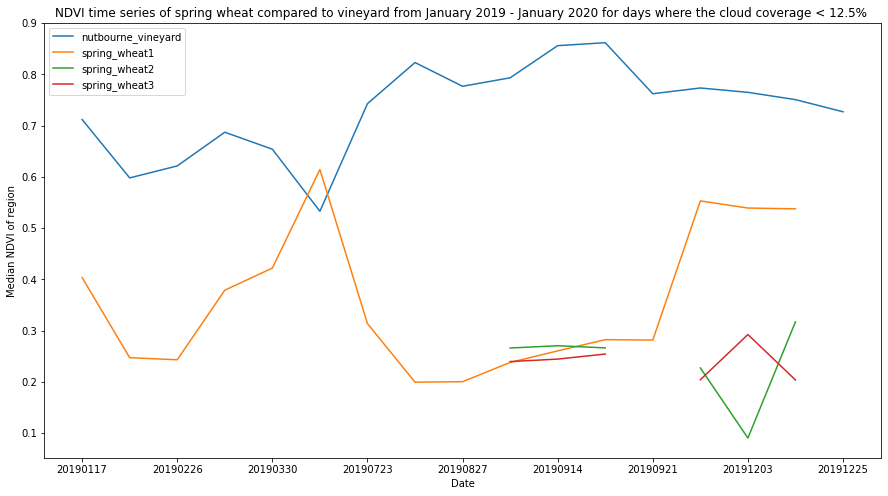

In [ ]:
compare_crops=[nutbourne_ndvi,swheat1_ndvi,swheat2_ndvi,swheat3_ndvi]
compare_crops_names=['nutbourne_vineyard','spring_wheat1','spring_wheat2','spring_wheat3']
plot_timeseries(compare_crops,compare_crops_names,'NDVI time series of spring wheat compared to vineyard from January 2019 - January 2020 for days where the cloud coverage < 12.5% ')


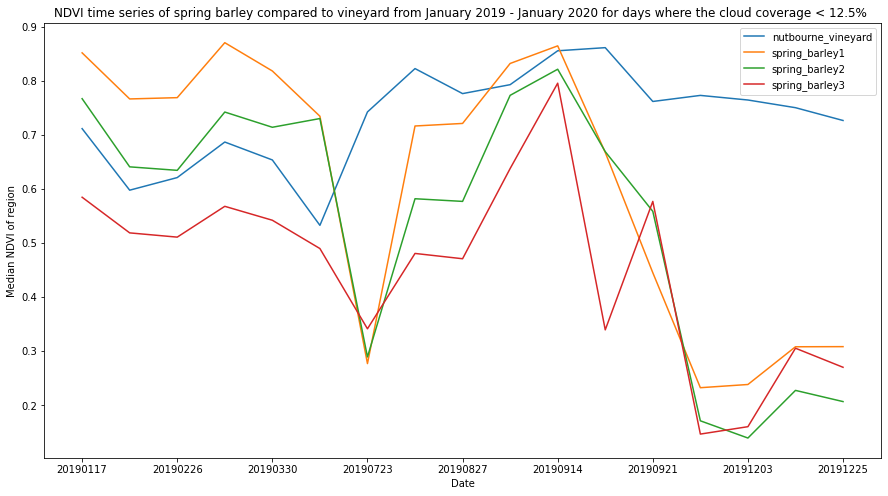

In [ ]:
compare_crops=[nutbourne_ndvi,sbarley1_ndvi,sbarley2_ndvi,sbarley3_ndvi]
compare_crops_names=['nutbourne_vineyard','spring_barley1','spring_barley2','spring_barley3']
plot_timeseries(compare_crops,compare_crops_names,'NDVI time series of spring barley compared to vineyard from January 2019 - January 2020 for days where the cloud coverage < 12.5% ')


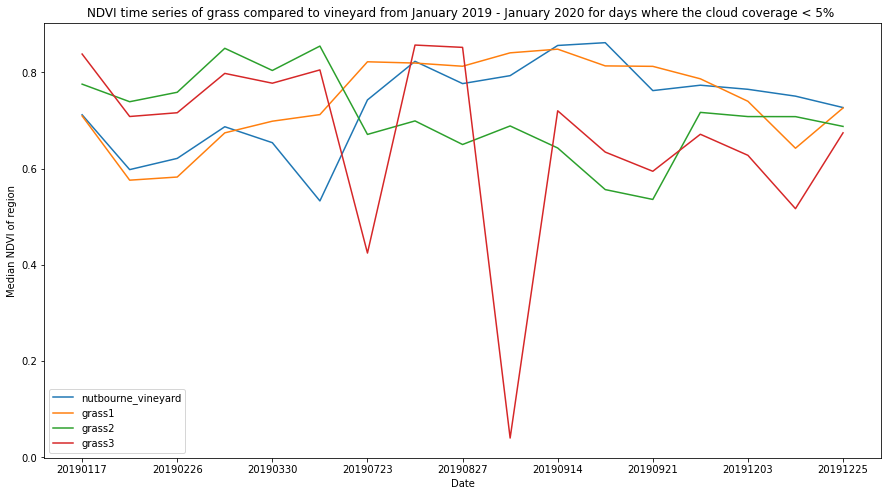

In [ ]:
compare_crops=[nutbourne_ndvi,grass1_ndvi,grass2_ndvi,grass3_ndvi]
compare_crops_names=['nutbourne_vineyard','grass1','grass2','grass3']
plot_timeseries(compare_crops,compare_crops_names,'NDVI time series of grass compared to vineyard from January 2019 - January 2020 for days where the cloud coverage < 12.5% ')
